# Vending Machine simulator

an effort to make a Monte-Carlo simulator for VM that will help to understand effect of different policies about product selection and refil strategy.

In [11]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
from matplotlib import pyplot as plt
from functools import partial

from simulator.vmSim import *
from simulator.strategies import FillUpAllExistingToMaxOnMinLevel
from simulator.optimizers import GridSearch, UtilityFunctions

# %matplotlib inline
%matplotlib widget
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Future considerations
- [ ] ML to find best strategy params
- [ ] ML to find best VM inventory within given constrains
- [ ] logic to cap number of VMs possible to refil during a day (how to choose which to refill?)
- [ ] map of locations (graph) with trasport costs b/w them for cost of trip estimate
- [ ] high level strategies: e.g. if one location is due for refill, then refill second in the same trip
- [ ] break downs?

# Some kind of introduction

In [4]:
# is a table with name and confidence interval of popularity
# popularity is just a number, it will later be normalized among all products, so relative is significant, not absolute
# log normal distribution is used to sample

products = {
    'coke': (50, 70),
    'beer': (10, 30),
    'water': (30, 50)
}

{'coke': 0.45204875969434427, 'beer': 0.2559599525527868, 'water': 0.29199128775286887}
[0.45204875969434427]


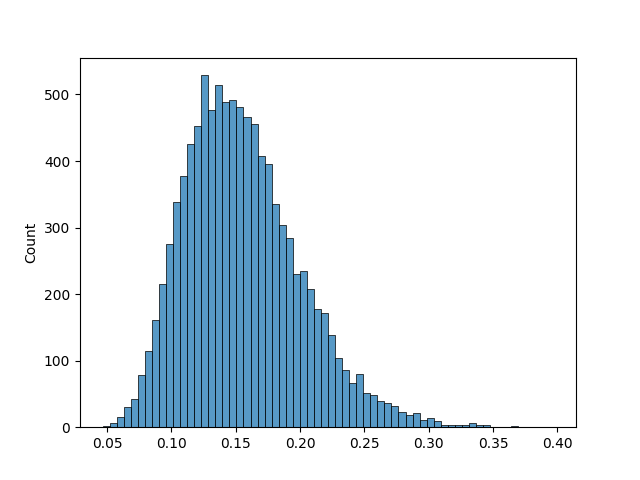

In [5]:
# example of Customer class
# it generates a random customer with preferences based on products popularity
c = Customer(products)
print(c.preferences)
print(c['coke'])

preferences = []
for _ in range(10_000):
    c = Customer(products)
    preferences.append(*c['beer'])
    
plt.figure()
sns.histplot(data=np.array(preferences))
plt.show()

In [6]:
local_time = SimulationTime() # basically a counter to keep things sync

In [7]:
# primary attribute of the location is it's traffic that may be random and given by confidence interval
l = Location('Sakh', traffic_conf_interval=(15, 30))
l.visits_today  # generates within confidence interval provided from lognormal distribution

25

In [8]:
# example of VendingMachine class
vm = VendingMachine(name='vm', location=l, time=local_time, columns=[
    ('coke', 10),
    ('coke', 10),
    ('beer', 10),
    ])
vm.refill({'coke': 15, 'beer': 20})
vm.available_products
vm.inventory, vm.capacity

(defaultdict(<function simulator.vmSim.VendingMachine.inventory.<locals>.<lambda>()>,
             {'coke': 15, 'beer': 10}),
 defaultdict(<function simulator.vmSim.VendingMachine.capacity.<locals>.<lambda>()>,
             {'coke': 20, 'beer': 10}))

# Refill strategies

In [37]:
class FillUpExistingToMaxOnMinLevel(BaseStrategy):
    def __init__(self, name: str, min_levels: dict[str, int], how_many_should_hit_min: int=1):
        self.name = name
        self.min_levels = min_levels
        self.how_many_should_hit_min = how_many_should_hit_min
    
    def make_refill_decision(self, vending_machine: VendingMachine) -> Decision:
        """
        takes state of provided vending machine and makes decision to refill or not
        if refill, returns product-ammount dict
        if not, returns False
        """
        self.vm = vending_machine
        decision: Decision = {}
        for name, ammount in self.vm.inventory.items():
            if ammount < self.min_levels[name]:
                decision[name] = self.vm.capacity[name]
        if len(decision) < self.how_many_should_hit_min:
            decision = False
        return decision

# Simulation

## Set up

In [104]:
local_time = SimulationTime()

# -- Locations --

low_traffic_loc = Location('boring place', traffic_conf_interval=(3, 10))
high_traffic_loc = Location('railroad', traffic_conf_interval=(20, 40))

# -- Products --

PRODUCTS = pd.DataFrame(columns=[
     'name',      'CI',    'size', 'cost', 'margin'], data=[
    ('papa_beer', (30, 50), 330,    250,     70),
    ('mama_beer', (10, 20), 330,    300,    100),
    ('baby_beer', ( 1,  5), 250,    200,    150),
    ('water',     (15, 25), 500,    100,     50),
])


# -- VMs --
vm1 = VendingMachine(name='vm1', location=low_traffic_loc, time=local_time, columns=[
    ('papa_beer', 40),
    ('papa_beer', 40),
    ('water', 30),
    ('water', 30),
])

vm2 = VendingMachine(name='vm2', location=high_traffic_loc, time=local_time, columns=[
    ('papa_beer', 40),
    ('mama_beer', 40),
    ('baby_beer', 40),
    ('water', 30),
])


VMs = [vm2]

# -- Strategies -- 
stg_1 = FillUpAllExistingToMaxOnMinLevel('best per grid search', min_levels={
    'papa_beer': 8,
    'mama_beer': 20,
    'baby_beer': 2,
    'water'    : 12,      
     }, how_many_should_hit_min=2)

s_topup_at_var = FillUpAllExistingToMaxOnMinLevel('top_based_on_pop', min_levels={
    'papa_beer': 15,
    'mama_beer': 10,
    'baby_beer': 5,
    'water'    : 15,      
})

STGs = {
    vm1: stg_1,
    vm2: stg_1,
}

## Running cycle

In [105]:
sim = Simulation('test run',
                 products=PRODUCTS, 
                 VMs=VMs,
                 STGs=STGs,
                 cycles=50,
                 local_time=local_time)

sim.run()

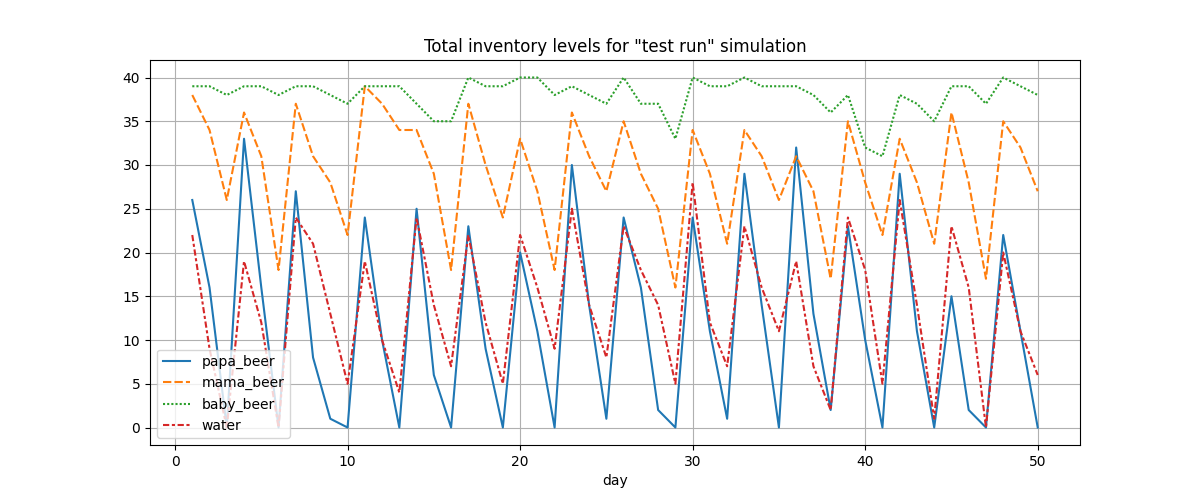

In [106]:
sim.plot_stat('total_inventory_levels')

Average inventory cost per day: 20,629.0 (sigma 5,229.7)


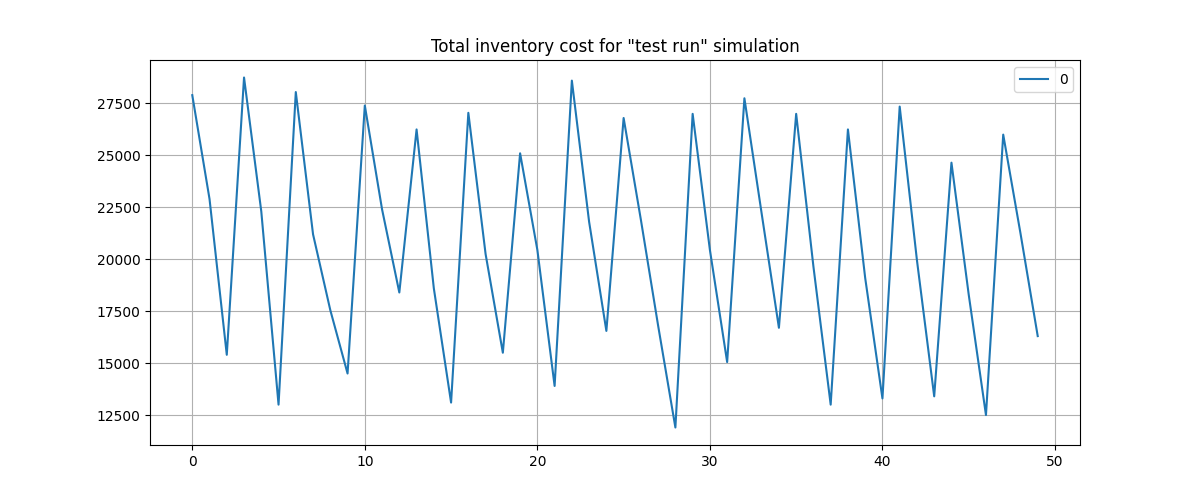

In [107]:
print(f'Average inventory cost per day: {np.mean(sim.total_inventory_cost):,.1f} (sigma {np.std(sim.total_inventory_cost):,.1f})')
sim.plot_stat('total_inventory_cost')

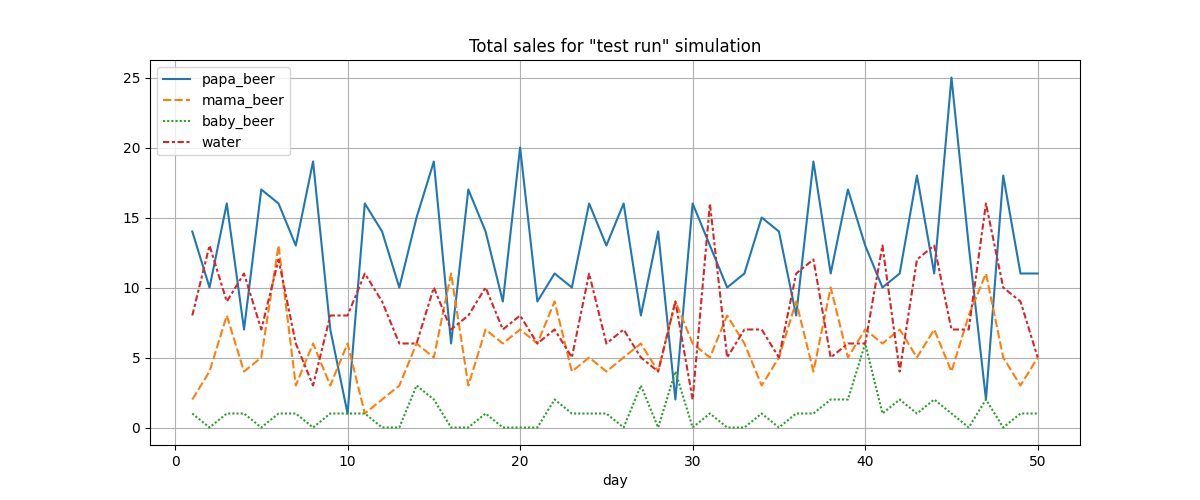

In [108]:
sim.plot_stat('total_sales')

Total sold outs for simulations: 32


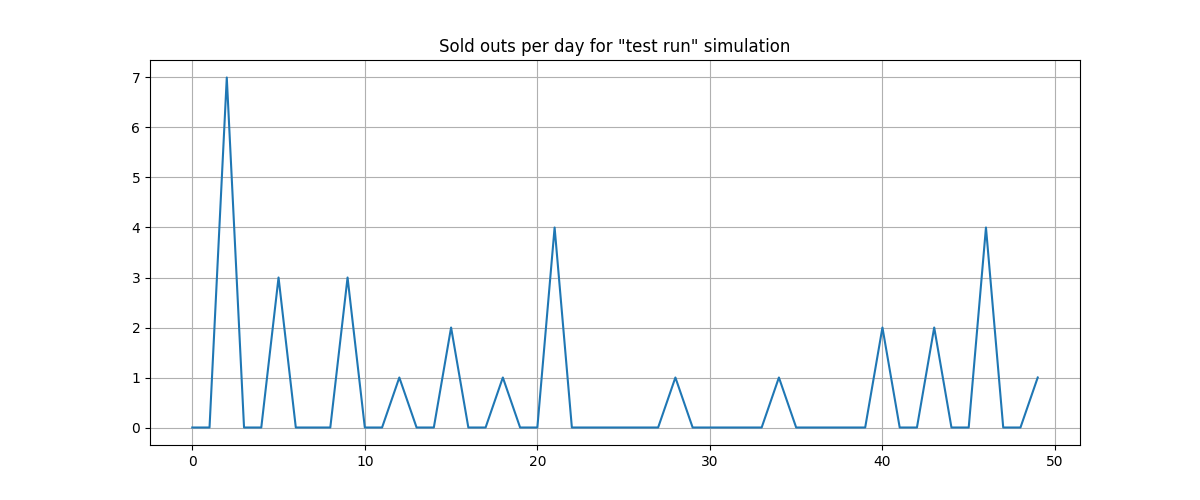

In [109]:
print(f'Total sold outs for simulations: {sum(sim.sold_outs_per_day)}')
sim.plot_stat('sold_outs_per_day')

Average profit per day: 2020.4 (sigma 413.6)


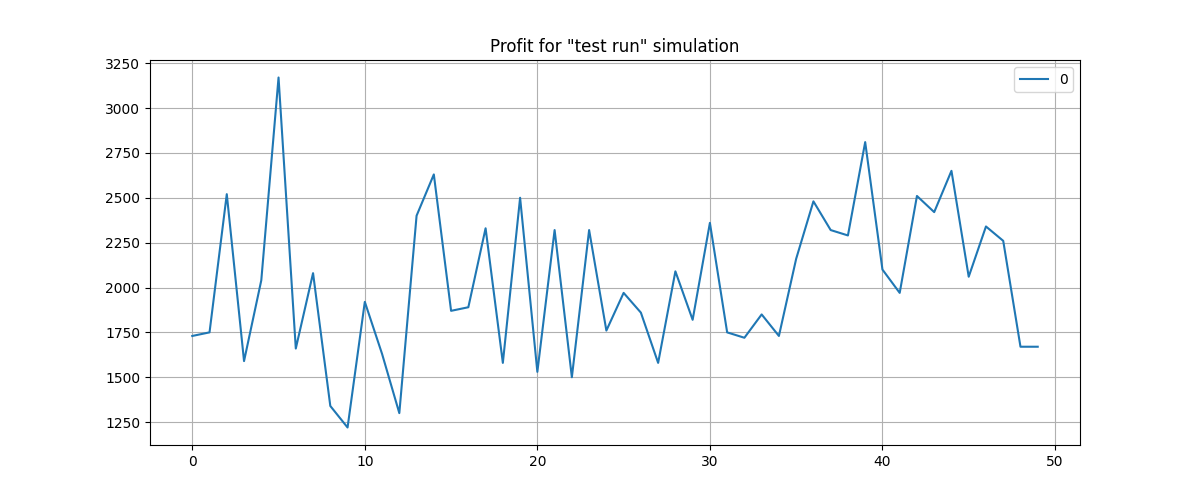

In [110]:
print(f'Average profit per day: {np.mean(sim.profit):.1f} (sigma {np.std(sim.profit):.1f})')
sim.plot_stat('profit')

Total top ups for simulations: 16


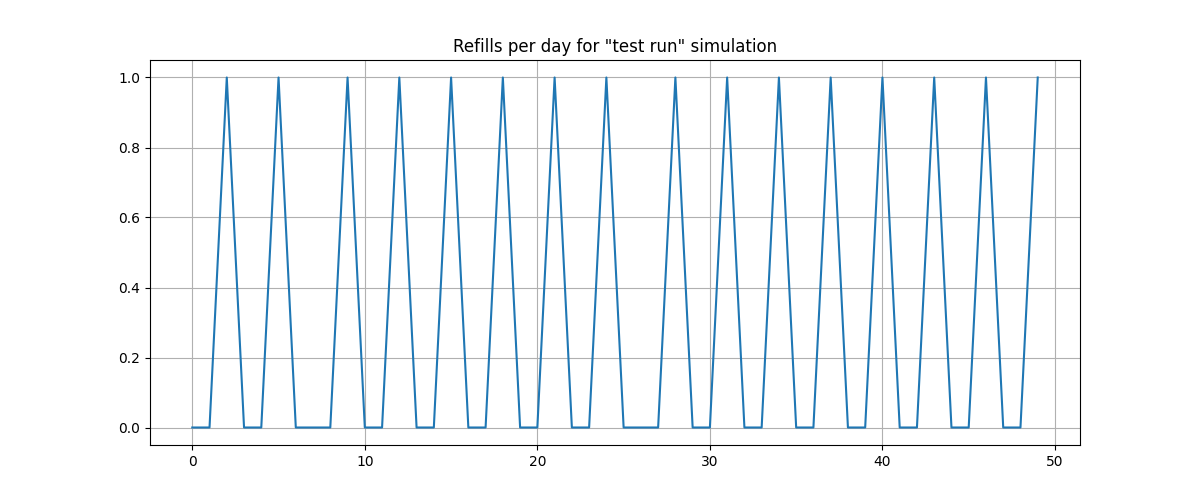

In [111]:
print(f'Total top ups for simulations: {sum(sim.refills_per_day)}')
sim.plot_stat('refills_per_day')

## Sort of economic model

In [2]:
interest_rate = 0.03
trip_cost = 500

def calc_utility(sim: Simulation, *, interest_rate: float, trip_cost: float) -> float:
    expenses = sum(sim.refills_per_day) * trip_cost + np.mean(sim.total_inventory_cost)/365 * len(sim.total_inventory_cost) * interest_rate
    profits = sum(sim.profit)[0]
    revenue = profits - expenses
    return revenue

In [112]:
calc_utility(sim, interest_rate=interest_rate, trip_cost=trip_cost)

92935.22328767124

# Parameters Optimization

## Best strategy params for given VM

In [3]:
# model set up

local_time = SimulationTime()

# -- Locations --

low_traffic_loc = Location('boring place', traffic_conf_interval=(3, 10))
high_traffic_loc = Location('railroad', traffic_conf_interval=(20, 40))

# -- Products --

PRODUCTS = pd.DataFrame(columns=[
     'name',      'CI',    'size', 'cost', 'margin'], data=[
    ('papa_beer', (30, 50), 330,    250,     70),
    ('mama_beer', (10, 20), 330,    300,    100),
    ('baby_beer', ( 1,  5), 250,    200,    150),
    ('water',     (15, 25), 500,    100,     50),
])


# -- VMs --
vm1 = VendingMachine(name='vm1', location=low_traffic_loc, time=local_time, columns=[
    ('papa_beer', 40),
    ('papa_beer', 40),
    ('water', 30),
    ('water', 30),
])

vm2 = VendingMachine(name='vm2', location=high_traffic_loc, time=local_time, columns=[
    ('papa_beer', 40),
    ('mama_beer', 40),
    ('baby_beer', 40),
    ('water', 30),
])


# -- strategies -- 

strategy = FillUpAllExistingToMaxOnMinLevel('test_one', min_levels={
    'papa_beer': 10,
    'mama_beer': 10,
    'baby_beer': 10,
    'water'    : 10,      
})

In [4]:
grid = [[0, 2, 4, 8, 12, 15, 20, 25, 30, 35]] #[[*range(0, 36, 10)]]
product_ranges = dict(zip(PRODUCTS.name.to_list(), grid * PRODUCTS.shape[1]))
extra = {'how_many_should_hit_min': [1]}
tuned_parameters = {**product_ranges, **extra}
tuned_parameters

{'papa_beer': [0, 2, 4, 8, 12, 15, 20, 25, 30, 35],
 'mama_beer': [0, 2, 4, 8, 12, 15, 20, 25, 30, 35],
 'baby_beer': [0, 2, 4, 8, 12, 15, 20, 25, 30, 35],
 'water': [0, 2, 4, 8, 12, 15, 20, 25, 30, 35],
 'how_many_should_hit_min': [1]}

In [5]:
sim = Simulation(
    'test_run',
    products=PRODUCTS,
    VMs=[vm2],
    STGs={vm2: strategy},
    local_time=local_time,
    cycles=100
)

In [12]:
gs = GridSearch(
    sim=sim,
    param_grid=tuned_parameters,
    scoring_function=partial(UtilityFunctions.revenue, interest_rate=interest_rate, trip_cost=trip_cost),
    random_sampling=0.05
)

In [13]:
gs.calc_scores()

Grid Search 500/500... rate=65.76 Hz, eta=0:00:00, total=0:00:09


In [34]:
import pickle

with open('simulator/test_run_scores.pck', mode='rb') as f:
    scores_matrix = pickle.load(f)  # gs.scores_matrix, 

with open('simulator/test_run_params.pck', mode='rb') as f:
    params_matrix = pickle.load(f)  # gs.params_matrix

In [30]:
from functools import reduce

def to_ix(i: int, shape):
    sizes = []
    for j in range(len(shape)):
        sizes.append(reduce(lambda next, acc: acc * next, shape[j:], 1))
    ixs = []
    for size in sizes:
        ixs.append(i // size)
        i -= ixs[-1] * size
    return tuple(ixs[1:])

calced_scores = gs.scores_matrix[gs.scores_matrix > 0]
min_score = calced_scores.min()
max_score = calced_scores.max()
score_range = max_score - min_score
scores_per = (gs.scores_matrix - min_score) / score_range

sorting = np.argsort(gs.scores_matrix, axis=None)
for score_ix in sorting[-20:][::-1]:
    if scores_per.item(score_ix) < 0:
        break
    print(gs.params_matrix[to_ix(score_ix, gs.scores_matrix.shape)], end='\t')
    print(f'{scores_per.item(score_ix):.1%}')


[25  1 12  8  8]	100.0%
[ 8  1  8  8 12]	95.7%
[35  1 25  2  4]	95.0%
[20  1 25  2 15]	91.3%
[20  1  4 15  2]	90.6%
[15  1 12 15  0]	90.2%
[ 2  1 15  0 12]	90.0%
[20  1 15  2  2]	89.9%
[8 1 4 0 0]	89.2%
[15  1 20  2  8]	88.3%
[25  1  2  0  2]	87.9%
[ 0  1  2  0 12]	86.4%
[15  1  2  8  4]	86.3%
[20  1 12  0  2]	86.0%
[30  1 25  0 15]	85.3%
[25  1  8 15  2]	85.1%
[4 1 0 8 2]	84.8%
[25  1 20  4 12]	84.8%
[25  1  8  2  2]	84.5%
[ 8  1  8 15 15]	84.5%


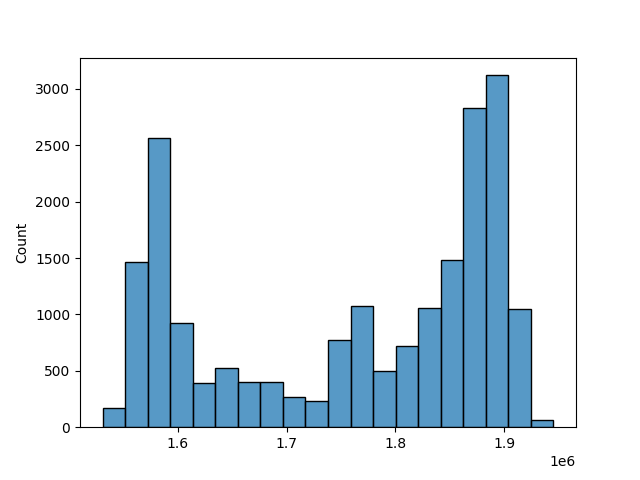

In [38]:
plt.figure()
sns.histplot(scores_matrix.flatten(), multiple='layer', bins=20)
plt.show()

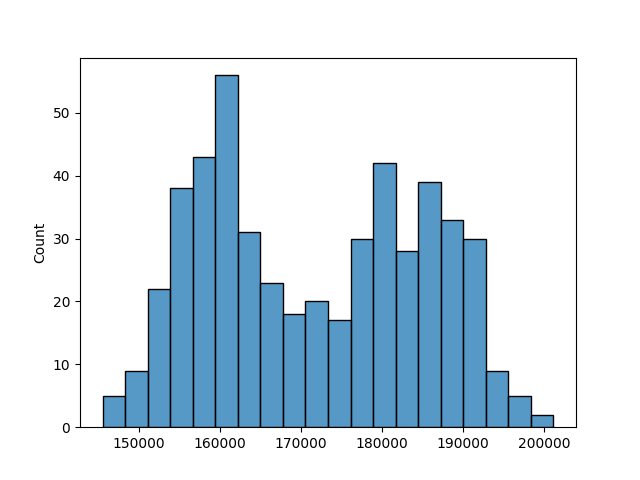

In [39]:
plt.figure()
# sns.histplot((scores_per[:, 0, :, :, :].flatten(), scores_per[:, 1, :, :, :].flatten()), multiple='layer')
sns.histplot(calced_scores.flatten(), multiple='layer', bins=20)
plt.show()

In [ ]:
plt.close()

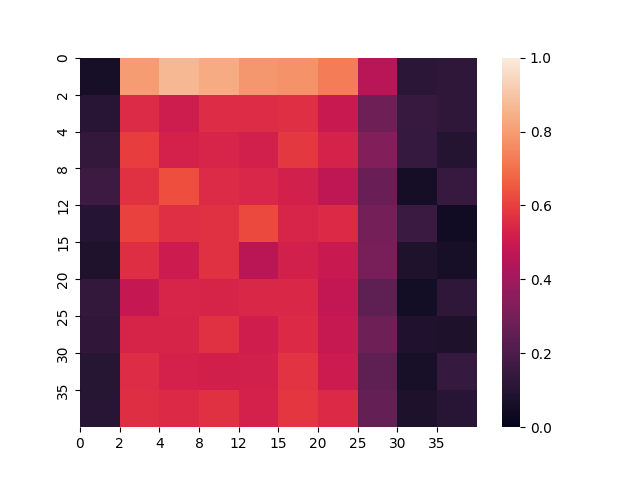

In [36]:
plt.figure()
sns.heatmap(scores_per[:, 0, 0, 4, :].squeeze(), vmin=0, vmax=1)
plt.xticks(range(len(grid[0])), labels=grid[0])
plt.yticks(range(len(grid[0])), labels=grid[0])
plt.show()

In [27]:
for i, val in enumerate(grid[0]):
    print(f'{i}:\t{val}')

0:	0
1:	2
2:	4
3:	8
4:	12
5:	15
6:	20
7:	25
8:	30
9:	35


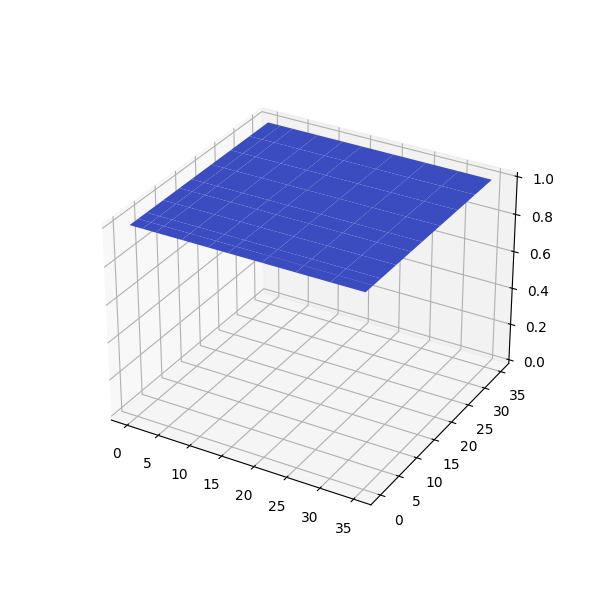

In [24]:
from matplotlib import cm

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(projection='3d')
X = Y = grid[0]
X, Y = np.meshgrid(X, Y)
Z = scores_per[0, 1, 3, :, :].squeeze()
ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0)
ax.set_zlim(0, 1)
plt.show()